# Training Data




To train DeepDISC, we must get metadata associated with each image.  Metadata contains information about object bounding boxes, segmenatation masks, classes, and other properties. We'll go through how to use scarlet and DeepDSIC preprocessing to produce metadata

In [2]:
import sys
import deepdisc

In [3]:
# Standard imports
import sys, os
import numpy as np
import time
import glob

import scarlet
import sep

import astropy.io.fits as fits
from astropy.wcs import WCS
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.coordinates import SkyCoord

from scarlet.display import AsinhMapping
from astropy.nddata import Cutout2D

# DeepDISC imports
import deepdisc.preprocessing.detection as detection
import deepdisc.preprocessing.process as process

from deepdisc.astrodet.hsc import get_tract_patch_from_coord, get_hsc_data

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib
import matplotlib.pyplot as plt

# use a better colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='gray', interpolation='none', origin='lower')
from skimage.util.shape import view_as_blocks
from matplotlib import colors

import pandas as pd
import h5py
import json

We'll use simulated images we've created using the BlendningToolkit.  You'll need to change directory paths below

### No input catalog


If you don't have an input catalog that contains detected objects, no worries! The object detection can be done with ```sep``` a standard code for astronmical image processing.


But first, we need to grab the images we want to preprocess.  The function ```get_cutout``` produces an image cutout from a larger "patch" and is specific to the file format of the data used in the tutorial.  You will need to make your own custom function to get an image saved in a different format

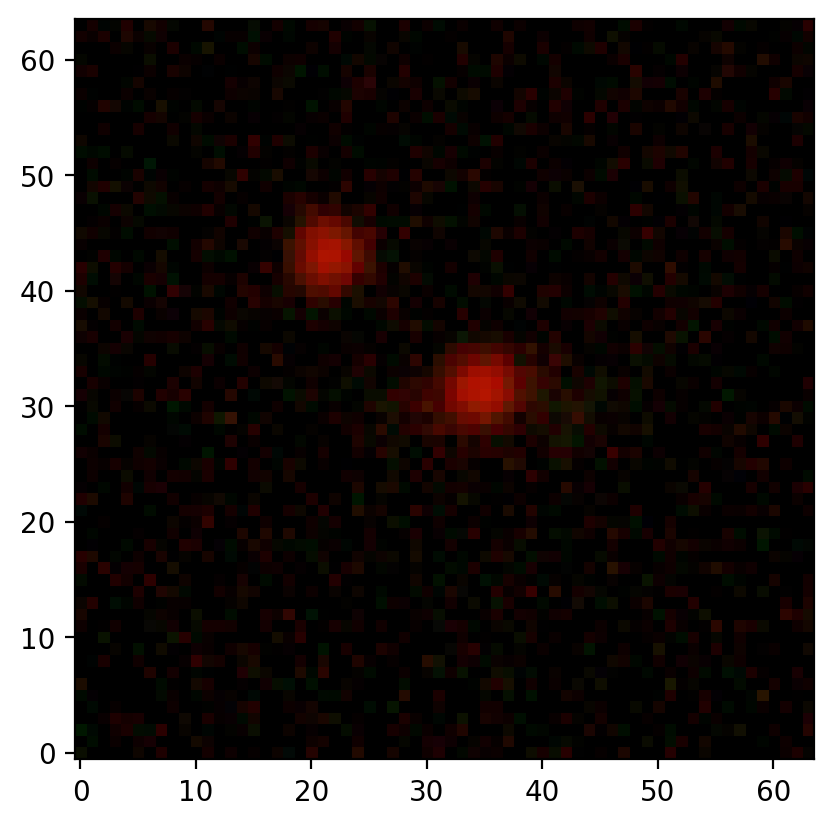

In [33]:
from deepdisc.data_format.image_readers import DC2ImageReader

reader = DC2ImageReader(norm="lupton",stretch=6000,     # ImageReader class to read the image from the disk and apply contrast scalings
                        Q=10, bandlist=[2,1,0])  

im = reader('/home/shared/hsc/DDTutorials/BTK/img_10.npy')
plt.imshow(im)

Now we can run detection and segmentation on the cutout image

To produce labels for an image, use ```deepdisc.preprocessing.detection.run_scarlet```.  The main inputs you will need are an image, a list of filters, and a psf (either an image or a gaussian standard deviation).
Check the API documentation for details. 

This will produce a few intermediate objects that contain all of the relevant information.  However, we format them into FITS files for ease of access.  This is done using ```deeepdisc.preprocess.process.write_scarlet_results_nomodels```

In [88]:

#This function is specific to the data format. You will need your own function to load custom data

def generate_training_data_example(dirpath, sp, outdir, plot_image=False, plot_stretch_Q=False, plot_scene=False,
                                   plot_likelihood=False, write_results=True, filters = ['u','g','r','i','z','y']):
    """
    Parameters
    ----------
    c : SkyCoord object
          The ra, dec pointing (single or lists of pointings)
    plot_image : bool
          Whether or not to plot the image
    plot_stretch_Q : bool
          Whether or not to plot different normalizations of your image using the stretch, Q parameters.
    plot_scene : bool
           Whether or not plot scene with scarlet
    plot_likelihood : bool
           Whether or not plot the log likelihood of the scarlet fitting
    write_results : bool
          Whether or not to write results to FITS file
    cutout_size : [int, int]
          Cutout shape of image
          
    Returns
    -------
    The scarlet image test in FITS files.
    
    """

    
    datas =  np.load(os.path.join(dirpath,f'img_{sp}.npy'))
    
    ### Run scarlet on image ###

    # Image pixel scale in arcsec/pixel
    ps = 0.2
    # Approximate PSF size, you can use a PSF image instead
    sigma_obs = gaussian_fwhm_to_sigma*0.8/ps
    
       
    # Run Scarlet
    out = detection.run_scarlet(datas, filters, catalog=None, lvl=2, sigma_model=1, sigma_obs=sigma_obs, psf=None, plot_scene=plot_scene,
                         max_chi2=1000000, morph_thresh=1, stretch=1, Q=5, 
                         plot_wavelet=False, plot_likelihood=plot_likelihood, plot_sources=False, add_ellipses=False,
                         add_labels=False, add_boxes=False, lvl_segmask=2, maskthresh=0.005,return_models=False)

    # Unpack output
    observation, starlet_sources, model_frame, catalog, segmentation_masks = out

    
    # Save Scarlet data to FITS file
    if write_results:
        filenames = process.write_scarlet_results_nomodels(datas, observation, starlet_sources, model_frame, 
                                             segmentation_masks, outdir=outdir, 
                                             filters=filters, s=f'img{sp}', catalog=None)
    
        print(f'\nSaved scarlet results as {filenames} \n')
    
        

In [90]:
%%time
dirpath = '/home/shared/hsc/DDTutorials/BTK/'
outdir='/home/g4merz/ddtutorials/'
generate_training_data_example(dirpath, sp=10,plot_scene=False, plot_likelihood=False, write_results=True, outdir=outdir)


Failed to initialize source 0
Failed to initialize source 1


Generate source catalog using wavelets
0.009320497512817383
Sep found  2 objects
Initializing starlet sources to be fit.
Modeling as extended sources
[<scarlet.source.SingleExtendedSource object at 0x7ffdc55920a0>, <scarlet.source.SingleExtendedSource object at 0x7ffdc55925b0>]
Fitting Blend model.
Scarlet ran for 15 iterations to logL = -1807000410.4332662
0.20857596397399902
Extracting deblended catalog.

Saved scarlet results as {'img_U': '/home/g4merz/ddtutorials/U_img10_scarlet_img.fits', 'img_G': '/home/g4merz/ddtutorials/G_img10_scarlet_img.fits', 'img_R': '/home/g4merz/ddtutorials/R_img10_scarlet_img.fits', 'img_I': '/home/g4merz/ddtutorials/I_img10_scarlet_img.fits', 'img_Z': '/home/g4merz/ddtutorials/Z_img10_scarlet_img.fits', 'img_Y': '/home/g4merz/ddtutorials/Y_img10_scarlet_img.fits', 'segmask': '/home/g4merz/ddtutorials/img10_scarlet_segmask.fits'} 

CPU times: user 249 ms, sys: 0 ns, total: 249 ms
Wall time: 262 ms


### Using an input catalog

If you already have a source catalog but still want to use scarlet to produce deblended footprints, you can supply a catalog to the `detection.run_scarlet` and `process.write_scarlet_results_nomodels` functions through the "catalog" keyword arg.  The catalog must be a Pandas DataFrame

Let's run a few more times to get a set of images

In [92]:
for i in range(0,20):
    generate_training_data_example(dirpath, sp=i,plot_scene=False, plot_likelihood=False, write_results=True, outdir=outdir)


Failed to initialize source 0
Failed to initialize source 1
Failed to initialize source 2
Failed to initialize source 3


Generate source catalog using wavelets
0.009469985961914062
Sep found  4 objects
Initializing starlet sources to be fit.
Modeling as extended sources
[<scarlet.source.CompactExtendedSource object at 0x7ffdc55bf7c0>, <scarlet.source.SingleExtendedSource object at 0x7ffdc55bf040>, <scarlet.source.SingleExtendedSource object at 0x7ffdc5592370>, <scarlet.source.SingleExtendedSource object at 0x7ffdc5592a00>]
Fitting Blend model.


Failed to initialize source 0
Failed to initialize source 0


Scarlet ran for 15 iterations to logL = -1831523633.7083669
0.30994224548339844
Extracting deblended catalog.

Saved scarlet results as {'img_U': '/home/g4merz/ddtutorials/U_img0_scarlet_img.fits', 'img_G': '/home/g4merz/ddtutorials/G_img0_scarlet_img.fits', 'img_R': '/home/g4merz/ddtutorials/R_img0_scarlet_img.fits', 'img_I': '/home/g4merz/ddtutorials/I_img0_scarlet_img.fits', 'img_Z': '/home/g4merz/ddtutorials/Z_img0_scarlet_img.fits', 'img_Y': '/home/g4merz/ddtutorials/Y_img0_scarlet_img.fits', 'segmask': '/home/g4merz/ddtutorials/img0_scarlet_segmask.fits'} 

Generate source catalog using wavelets
0.008887290954589844
Sep found  1 objects
Initializing starlet sources to be fit.
Modeling as extended sources
Fitting Blend model.
Scarlet ran for 8 iterations to logL = -1784792336.0745447
0.08604812622070312
Extracting deblended catalog.

Saved scarlet results as {'img_U': '/home/g4merz/ddtutorials/U_img1_scarlet_img.fits', 'img_G': '/home/g4merz/ddtutorials/G_img1_scarlet_img.fits', '

Failed to initialize source 0
Failed to initialize source 1


Modeling as extended sources
Fitting Blend model.
Scarlet ran for 8 iterations to logL = -1826267451.160925
0.08216619491577148
Extracting deblended catalog.

Saved scarlet results as {'img_U': '/home/g4merz/ddtutorials/U_img2_scarlet_img.fits', 'img_G': '/home/g4merz/ddtutorials/G_img2_scarlet_img.fits', 'img_R': '/home/g4merz/ddtutorials/R_img2_scarlet_img.fits', 'img_I': '/home/g4merz/ddtutorials/I_img2_scarlet_img.fits', 'img_Z': '/home/g4merz/ddtutorials/Z_img2_scarlet_img.fits', 'img_Y': '/home/g4merz/ddtutorials/Y_img2_scarlet_img.fits', 'segmask': '/home/g4merz/ddtutorials/img2_scarlet_segmask.fits'} 

Generate source catalog using wavelets
0.008904695510864258
Sep found  2 objects
Initializing starlet sources to be fit.
Modeling as extended sources
[<scarlet.source.CompactExtendedSource object at 0x7ffdc559ddf0>, <scarlet.source.SingleExtendedSource object at 0x7ffdc559daf0>]
Fitting Blend model.


Failed to initialize source 0


Scarlet ran for 15 iterations to logL = -1878822309.4239354
0.2056899070739746
Extracting deblended catalog.

Saved scarlet results as {'img_U': '/home/g4merz/ddtutorials/U_img3_scarlet_img.fits', 'img_G': '/home/g4merz/ddtutorials/G_img3_scarlet_img.fits', 'img_R': '/home/g4merz/ddtutorials/R_img3_scarlet_img.fits', 'img_I': '/home/g4merz/ddtutorials/I_img3_scarlet_img.fits', 'img_Z': '/home/g4merz/ddtutorials/Z_img3_scarlet_img.fits', 'img_Y': '/home/g4merz/ddtutorials/Y_img3_scarlet_img.fits', 'segmask': '/home/g4merz/ddtutorials/img3_scarlet_segmask.fits'} 

Generate source catalog using wavelets
0.008850336074829102
Sep found  1 objects
Initializing starlet sources to be fit.
Modeling as extended sources
Fitting Blend model.


Failed to initialize source 0
Failed to initialize source 1
Failed to initialize source 2


Scarlet ran for 15 iterations to logL = -1844207731.018729
0.16255831718444824
Extracting deblended catalog.

Saved scarlet results as {'img_U': '/home/g4merz/ddtutorials/U_img4_scarlet_img.fits', 'img_G': '/home/g4merz/ddtutorials/G_img4_scarlet_img.fits', 'img_R': '/home/g4merz/ddtutorials/R_img4_scarlet_img.fits', 'img_I': '/home/g4merz/ddtutorials/I_img4_scarlet_img.fits', 'img_Z': '/home/g4merz/ddtutorials/Z_img4_scarlet_img.fits', 'img_Y': '/home/g4merz/ddtutorials/Y_img4_scarlet_img.fits', 'segmask': '/home/g4merz/ddtutorials/img4_scarlet_segmask.fits'} 

Generate source catalog using wavelets
0.009196043014526367
Sep found  3 objects
Initializing starlet sources to be fit.
Modeling as extended sources
[<scarlet.source.SingleExtendedSource object at 0x7ffdc559ddc0>, <scarlet.source.SingleExtendedSource object at 0x7ffdc55bfc10>, <scarlet.source.SingleExtendedSource object at 0x7ffdc5592280>]
Fitting Blend model.


Failed to initialize source 0


Scarlet ran for 15 iterations to logL = -1827406811.2191632
0.27791690826416016
Extracting deblended catalog.

Saved scarlet results as {'img_U': '/home/g4merz/ddtutorials/U_img5_scarlet_img.fits', 'img_G': '/home/g4merz/ddtutorials/G_img5_scarlet_img.fits', 'img_R': '/home/g4merz/ddtutorials/R_img5_scarlet_img.fits', 'img_I': '/home/g4merz/ddtutorials/I_img5_scarlet_img.fits', 'img_Z': '/home/g4merz/ddtutorials/Z_img5_scarlet_img.fits', 'img_Y': '/home/g4merz/ddtutorials/Y_img5_scarlet_img.fits', 'segmask': '/home/g4merz/ddtutorials/img5_scarlet_segmask.fits'} 

Generate source catalog using wavelets
0.008867263793945312
Sep found  1 objects
Initializing starlet sources to be fit.
Modeling as extended sources
Fitting Blend model.
Scarlet ran for 13 iterations to logL = -1816561854.356553
0.14150547981262207
Extracting deblended catalog.


Failed to initialize source 0
Failed to initialize source 1



Saved scarlet results as {'img_U': '/home/g4merz/ddtutorials/U_img6_scarlet_img.fits', 'img_G': '/home/g4merz/ddtutorials/G_img6_scarlet_img.fits', 'img_R': '/home/g4merz/ddtutorials/R_img6_scarlet_img.fits', 'img_I': '/home/g4merz/ddtutorials/I_img6_scarlet_img.fits', 'img_Z': '/home/g4merz/ddtutorials/Z_img6_scarlet_img.fits', 'img_Y': '/home/g4merz/ddtutorials/Y_img6_scarlet_img.fits', 'segmask': '/home/g4merz/ddtutorials/img6_scarlet_segmask.fits'} 

Generate source catalog using wavelets
0.008844137191772461
Sep found  2 objects
Initializing starlet sources to be fit.
Modeling as extended sources
[<scarlet.source.SingleExtendedSource object at 0x7ffdc5592280>, <scarlet.source.SingleExtendedSource object at 0x7ffdc55922e0>]
Fitting Blend model.


Failed to initialize source 0
Failed to initialize source 1


Scarlet ran for 15 iterations to logL = -1760188597.3627276
0.203261137008667
Extracting deblended catalog.

Saved scarlet results as {'img_U': '/home/g4merz/ddtutorials/U_img7_scarlet_img.fits', 'img_G': '/home/g4merz/ddtutorials/G_img7_scarlet_img.fits', 'img_R': '/home/g4merz/ddtutorials/R_img7_scarlet_img.fits', 'img_I': '/home/g4merz/ddtutorials/I_img7_scarlet_img.fits', 'img_Z': '/home/g4merz/ddtutorials/Z_img7_scarlet_img.fits', 'img_Y': '/home/g4merz/ddtutorials/Y_img7_scarlet_img.fits', 'segmask': '/home/g4merz/ddtutorials/img7_scarlet_segmask.fits'} 

Generate source catalog using wavelets
0.008911371231079102
Sep found  2 objects
Initializing starlet sources to be fit.
Modeling as extended sources
[<scarlet.source.SingleExtendedSource object at 0x7ffdc55922b0>, <scarlet.source.CompactExtendedSource object at 0x7ffdc5592af0>]
Fitting Blend model.


Failed to initialize source 0
Failed to initialize source 1
Failed to initialize source 2
Failed to initialize source 3


Scarlet ran for 15 iterations to logL = -1828460105.7956543
0.2051560878753662
Extracting deblended catalog.

Saved scarlet results as {'img_U': '/home/g4merz/ddtutorials/U_img8_scarlet_img.fits', 'img_G': '/home/g4merz/ddtutorials/G_img8_scarlet_img.fits', 'img_R': '/home/g4merz/ddtutorials/R_img8_scarlet_img.fits', 'img_I': '/home/g4merz/ddtutorials/I_img8_scarlet_img.fits', 'img_Z': '/home/g4merz/ddtutorials/Z_img8_scarlet_img.fits', 'img_Y': '/home/g4merz/ddtutorials/Y_img8_scarlet_img.fits', 'segmask': '/home/g4merz/ddtutorials/img8_scarlet_segmask.fits'} 

Generate source catalog using wavelets
0.009164571762084961
Sep found  4 objects
Initializing starlet sources to be fit.
Modeling as extended sources
[<scarlet.source.SingleExtendedSource object at 0x7ffdc561bb20>, <scarlet.source.CompactExtendedSource object at 0x7ffdc559d730>, <scarlet.source.SingleExtendedSource object at 0x7ffdc559d970>, <scarlet.source.SingleExtendedSource object at 0x7ffdc554e7f0>]
Fitting Blend model.


Failed to initialize source 0
Failed to initialize source 1


Scarlet ran for 15 iterations to logL = -1767312853.6047337
0.29569172859191895
Extracting deblended catalog.

Saved scarlet results as {'img_U': '/home/g4merz/ddtutorials/U_img9_scarlet_img.fits', 'img_G': '/home/g4merz/ddtutorials/G_img9_scarlet_img.fits', 'img_R': '/home/g4merz/ddtutorials/R_img9_scarlet_img.fits', 'img_I': '/home/g4merz/ddtutorials/I_img9_scarlet_img.fits', 'img_Z': '/home/g4merz/ddtutorials/Z_img9_scarlet_img.fits', 'img_Y': '/home/g4merz/ddtutorials/Y_img9_scarlet_img.fits', 'segmask': '/home/g4merz/ddtutorials/img9_scarlet_segmask.fits'} 

Generate source catalog using wavelets
0.008974790573120117
Sep found  2 objects
Initializing starlet sources to be fit.
Modeling as extended sources
[<scarlet.source.SingleExtendedSource object at 0x7ffdc7cda0d0>, <scarlet.source.SingleExtendedSource object at 0x7ffdc561bc10>]
Fitting Blend model.


Failed to initialize source 0
Failed to initialize source 1


Scarlet ran for 15 iterations to logL = -1807000410.4332662
0.20850133895874023
Extracting deblended catalog.

Saved scarlet results as {'img_U': '/home/g4merz/ddtutorials/U_img10_scarlet_img.fits', 'img_G': '/home/g4merz/ddtutorials/G_img10_scarlet_img.fits', 'img_R': '/home/g4merz/ddtutorials/R_img10_scarlet_img.fits', 'img_I': '/home/g4merz/ddtutorials/I_img10_scarlet_img.fits', 'img_Z': '/home/g4merz/ddtutorials/Z_img10_scarlet_img.fits', 'img_Y': '/home/g4merz/ddtutorials/Y_img10_scarlet_img.fits', 'segmask': '/home/g4merz/ddtutorials/img10_scarlet_segmask.fits'} 

Generate source catalog using wavelets
0.009055137634277344
Sep found  2 objects
Initializing starlet sources to be fit.
Modeling as extended sources
[<scarlet.source.SingleExtendedSource object at 0x7ffdc5a11880>, <scarlet.source.SingleExtendedSource object at 0x7ffdc55a6520>]
Fitting Blend model.


Failed to initialize source 0
Failed to initialize source 1
Failed to initialize source 2


Scarlet ran for 13 iterations to logL = -1792080948.4206424
0.1842482089996338
Extracting deblended catalog.

Saved scarlet results as {'img_U': '/home/g4merz/ddtutorials/U_img11_scarlet_img.fits', 'img_G': '/home/g4merz/ddtutorials/G_img11_scarlet_img.fits', 'img_R': '/home/g4merz/ddtutorials/R_img11_scarlet_img.fits', 'img_I': '/home/g4merz/ddtutorials/I_img11_scarlet_img.fits', 'img_Z': '/home/g4merz/ddtutorials/Z_img11_scarlet_img.fits', 'img_Y': '/home/g4merz/ddtutorials/Y_img11_scarlet_img.fits', 'segmask': '/home/g4merz/ddtutorials/img11_scarlet_segmask.fits'} 

Generate source catalog using wavelets
0.009030580520629883
Sep found  3 objects
Initializing starlet sources to be fit.
Modeling as extended sources
[<scarlet.source.SingleExtendedSource object at 0x7ffdc5ade580>, <scarlet.source.SingleExtendedSource object at 0x7ffdc561baf0>, <scarlet.source.SingleExtendedSource object at 0x7ffdc55a65e0>]
Fitting Blend model.


Failed to initialize source 0
Failed to initialize source 0
Failed to initialize source 1
Failed to initialize source 2


Scarlet ran for 14 iterations to logL = -1815909981.9912171
0.23706746101379395
Extracting deblended catalog.

Saved scarlet results as {'img_U': '/home/g4merz/ddtutorials/U_img12_scarlet_img.fits', 'img_G': '/home/g4merz/ddtutorials/G_img12_scarlet_img.fits', 'img_R': '/home/g4merz/ddtutorials/R_img12_scarlet_img.fits', 'img_I': '/home/g4merz/ddtutorials/I_img12_scarlet_img.fits', 'img_Z': '/home/g4merz/ddtutorials/Z_img12_scarlet_img.fits', 'img_Y': '/home/g4merz/ddtutorials/Y_img12_scarlet_img.fits', 'segmask': '/home/g4merz/ddtutorials/img12_scarlet_segmask.fits'} 

Generate source catalog using wavelets
0.008764266967773438
Sep found  1 objects
Initializing starlet sources to be fit.
Modeling as extended sources
Fitting Blend model.
Scarlet ran for 9 iterations to logL = -1810927681.806809
0.09486675262451172
Extracting deblended catalog.

Saved scarlet results as {'img_U': '/home/g4merz/ddtutorials/U_img13_scarlet_img.fits', 'img_G': '/home/g4merz/ddtutorials/G_img13_scarlet_img.

Failed to initialize source 0
Failed to initialize source 1


Scarlet ran for 14 iterations to logL = -1790452906.1121836
0.23726511001586914
Extracting deblended catalog.

Saved scarlet results as {'img_U': '/home/g4merz/ddtutorials/U_img14_scarlet_img.fits', 'img_G': '/home/g4merz/ddtutorials/G_img14_scarlet_img.fits', 'img_R': '/home/g4merz/ddtutorials/R_img14_scarlet_img.fits', 'img_I': '/home/g4merz/ddtutorials/I_img14_scarlet_img.fits', 'img_Z': '/home/g4merz/ddtutorials/Z_img14_scarlet_img.fits', 'img_Y': '/home/g4merz/ddtutorials/Y_img14_scarlet_img.fits', 'segmask': '/home/g4merz/ddtutorials/img14_scarlet_segmask.fits'} 

Generate source catalog using wavelets
0.008940935134887695
Sep found  2 objects
Initializing starlet sources to be fit.
Modeling as extended sources
[<scarlet.source.SingleExtendedSource object at 0x7ffdc5a212b0>, <scarlet.source.SingleExtendedSource object at 0x7ffdc5592f70>]
Fitting Blend model.


Failed to initialize source 0
Failed to initialize source 1
Failed to initialize source 0
Failed to initialize source 1
Failed to initialize source 2


Scarlet ran for 12 iterations to logL = -1773971304.7964523
0.17096900939941406
Extracting deblended catalog.

Saved scarlet results as {'img_U': '/home/g4merz/ddtutorials/U_img15_scarlet_img.fits', 'img_G': '/home/g4merz/ddtutorials/G_img15_scarlet_img.fits', 'img_R': '/home/g4merz/ddtutorials/R_img15_scarlet_img.fits', 'img_I': '/home/g4merz/ddtutorials/I_img15_scarlet_img.fits', 'img_Z': '/home/g4merz/ddtutorials/Z_img15_scarlet_img.fits', 'img_Y': '/home/g4merz/ddtutorials/Y_img15_scarlet_img.fits', 'segmask': '/home/g4merz/ddtutorials/img15_scarlet_segmask.fits'} 

Generate source catalog using wavelets
0.00885152816772461
Sep found  2 objects
Initializing starlet sources to be fit.
Modeling as extended sources
[<scarlet.source.SingleExtendedSource object at 0x7ffdc5a21af0>, <scarlet.source.SingleExtendedSource object at 0x7ffdc5592be0>]
Fitting Blend model.
Scarlet ran for 5 iterations to logL = -1796790841.2292411
0.07871294021606445
Extracting deblended catalog.

Saved scarlet 

Failed to initialize source 0
Failed to initialize source 1


Scarlet ran for 15 iterations to logL = -1771448773.4199839
0.25330400466918945
Extracting deblended catalog.

Saved scarlet results as {'img_U': '/home/g4merz/ddtutorials/U_img17_scarlet_img.fits', 'img_G': '/home/g4merz/ddtutorials/G_img17_scarlet_img.fits', 'img_R': '/home/g4merz/ddtutorials/R_img17_scarlet_img.fits', 'img_I': '/home/g4merz/ddtutorials/I_img17_scarlet_img.fits', 'img_Z': '/home/g4merz/ddtutorials/Z_img17_scarlet_img.fits', 'img_Y': '/home/g4merz/ddtutorials/Y_img17_scarlet_img.fits', 'segmask': '/home/g4merz/ddtutorials/img17_scarlet_segmask.fits'} 

Generate source catalog using wavelets
0.009117603302001953
Sep found  2 objects
Initializing starlet sources to be fit.
Modeling as extended sources
[<scarlet.source.SingleExtendedSource object at 0x7ffdc55ae250>, <scarlet.source.SingleExtendedSource object at 0x7ffdc55ae8e0>]
Fitting Blend model.


Failed to initialize source 0
Failed to initialize source 1
Failed to initialize source 2
Failed to initialize source 3


Scarlet ran for 15 iterations to logL = -2032595638.3338776
0.21849632263183594
Extracting deblended catalog.

Saved scarlet results as {'img_U': '/home/g4merz/ddtutorials/U_img18_scarlet_img.fits', 'img_G': '/home/g4merz/ddtutorials/G_img18_scarlet_img.fits', 'img_R': '/home/g4merz/ddtutorials/R_img18_scarlet_img.fits', 'img_I': '/home/g4merz/ddtutorials/I_img18_scarlet_img.fits', 'img_Z': '/home/g4merz/ddtutorials/Z_img18_scarlet_img.fits', 'img_Y': '/home/g4merz/ddtutorials/Y_img18_scarlet_img.fits', 'segmask': '/home/g4merz/ddtutorials/img18_scarlet_segmask.fits'} 

Generate source catalog using wavelets
0.009076833724975586
Sep found  4 objects
Initializing starlet sources to be fit.
Modeling as extended sources
[<scarlet.source.SingleExtendedSource object at 0x7ffdc55aef40>, <scarlet.source.CompactExtendedSource object at 0x7ffdc55aeb20>, <scarlet.source.SingleExtendedSource object at 0x7ffdc5a24490>, <scarlet.source.SingleExtendedSource object at 0x7ffdc55bf6a0>]
Fitting Blend m

### Annotation generation

Now we can reformat the scarlet output to the format that detectron2 (and thus deepdisc) expects.  This is done by creating a list of dictionaries, with each dict containing annotations that have the ground truth information.  Take a look at the detectron2 docs for more information on the format expected

In [93]:
from deepdisc.data_format.file_io import DDLoader
from deepdisc.data_format.annotation_functions.annotate_dc2 import annotate_dc2

Each image cutout is saved into separate FITS files per band, along with mask files (which contain the object location/footprint information). Here we create a DDLoader class, which helps gather output files and format them

In [94]:
loader = DDLoader().generate_filedict('/home/g4merz/ddtutorials/', ['U', 'G', 'R', 'I', 'Z','Y'], '*_scarlet_img.fits', '*_scarlet_segmask.fits')
filedict = loader.filedict
img_files = np.transpose([filedict[filt]["img"] for filt in filedict["filters"]])

In [124]:
from deepdisc.data_format import conversions
from deepdisc.data_format.conversions import fitsim_to_numpy
from deepdisc.data_format.annotation_functions.annotate_nocat import annotate_nocat

Format the files for deepdisc

In [111]:

dataset_dicts=[]
dataset_dicts = loader.generate_dataset_dict(annotate_nocat,dirpath=outdir).get_dataset()  


Now ```dataset_dicts``` contains the formatted ground truth for deepdisc.  We save it in a json file below

In [114]:
from deepdisc.data_format.file_io import convert_to_json

dfile ='/home/g4merz/ddtutorials/train_dicts.json'
convert_to_json(dataset_dicts, dfile)

Caching COCO format annotations at '/home/g4merz/ddtutorials/train_dicts.json' ...


It may also be useful to format the FITS images by scarlet into numpy .npy files.  For convenience, this can be done using some conversion utilities

In [121]:
importlib.reload(deepdisc.data_format.conversions)
from deepdisc.data_format.conversions import fitsim_to_numpy

In [122]:
fitsim_to_numpy(img_files,'/home/g4merz/ddtutorials/')

Clean up the FITS files

In [123]:
for file in glob.glob('/home/g4merz/ddtutorials/*.fits'):
    os.remove(file)

Now you have everything you need to run DeepDISC!